# Objetivo

Treinar um modelo de rede convolucional capaz de classificar imagens e, neste caso, diferenciar cachorros de gatos.

Imagens = ../../data/imagens_caes_gatos

Base Kaggle com imagens de cães e gatos: https://www.kaggle.com/datasets/moazeldsokyx/dogs-vs-cats

# Importando bibliotecas

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os, cv2

# Deep Learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

# Validação do modelo
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Indicando pastas e arquivos

In [4]:
# Caminho da pasta
path_imagens = '../../data/imagens_caes_gatos/'
pasta_imagens = Path(path_imagens)

In [10]:
file_paths = list(pasta_imagens.glob(r'**/train/*/*.jpg'))

In [12]:
len(file_paths)

20000

# Tratamento dos dados

Iremos armanezar as targets e as imagens em uma lista. Porém, primeiramente será feito um pré-processamento em cada uma das imagens, para redimensioná-las e normalizar o intervalo de pixels entre 0 e 1.

In [25]:
# Listas de labels e imagens
labels = []
images = []

# Tamanho da imagem (64 x 64 pixels)
image_size = 64

for filepath in file_paths:
    # Split do path para obter nome do animal (target)
    path_split = os.path.split(filepath)
    label_animal = os.path.split(path_split[0])[1]

    labels.append(label_animal)

    # Obtem imagem com cv2 (opencv)
    img = cv2.imread(str(filepath))

    # Redimensionamento e normalização da imagem
    img_processada = cv2.resize(img, (image_size, image_size)).astype('float32') / 255

    images.append(img_processada)

# Converte lista de imagens e labes em np.array
images = np.array(images)
labels = np.array(labels)

In [27]:
# pd.Series com paths
pd_filepaths = pd.Series(file_paths, name='Filepath').astype(str)
pd_filepaths

0        ..\..\data\imagens_caes_gatos\train\cats\cat.0...
1        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
2        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
3        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
4        ..\..\data\imagens_caes_gatos\train\cats\cat.1...
                               ...                        
19995    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19996    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19997    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19998    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
19999    ..\..\data\imagens_caes_gatos\train\dogs\dog.9...
Name: Filepath, Length: 20000, dtype: object

In [28]:
# pd.Series com labels
pd_labels = pd.Series(labels, name='Label').astype(str)
pd_labels

0        cats
1        cats
2        cats
3        cats
4        cats
         ... 
19995    dogs
19996    dogs
19997    dogs
19998    dogs
19999    dogs
Name: Label, Length: 20000, dtype: object

In [29]:
# DF concatenado
df = pd.concat([pd_filepaths, pd_labels], axis=1)

# Dados estão ordenadas pela variável target, é interessante dar um shuffl
df

,Filepath,Label
0,..\..\data\imagens_caes_gatos\train\cats\cat.0...,cats
1,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
2,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
3,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
4,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
...,...,...
19995,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs
19996,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs
19997,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs
19998,..\..\data\imagens_caes_gatos\train\dogs\dog.9...,dogs


In [30]:
# Pegar sample de todo o DF apenas para aplicar aleatoriedade
df = df.sample(frac=1).reset_index(drop=True)

df

,Filepath,Label
0,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
1,..\..\data\imagens_caes_gatos\train\dogs\dog.2...,dogs
2,..\..\data\imagens_caes_gatos\train\dogs\dog.1...,dogs
3,..\..\data\imagens_caes_gatos\train\cats\cat.8...,cats
4,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
...,...,...
19995,..\..\data\imagens_caes_gatos\train\cats\cat.1...,cats
19996,..\..\data\imagens_caes_gatos\train\dogs\dog.1...,dogs
19997,..\..\data\imagens_caes_gatos\train\cats\cat.5...,cats
19998,..\..\data\imagens_caes_gatos\train\cats\cat.8...,cats


## DF singles

In [33]:
# Cópia do DF com apenas um registro para cada classe
df_singles = df.copy().drop_duplicates(subset=['Label']).reset_index(drop=True)
df_singles

# Número de classes
num_classes = df_singles['Label'].nunique()
print(num_classes)

2


# Visualização prévia de imagens

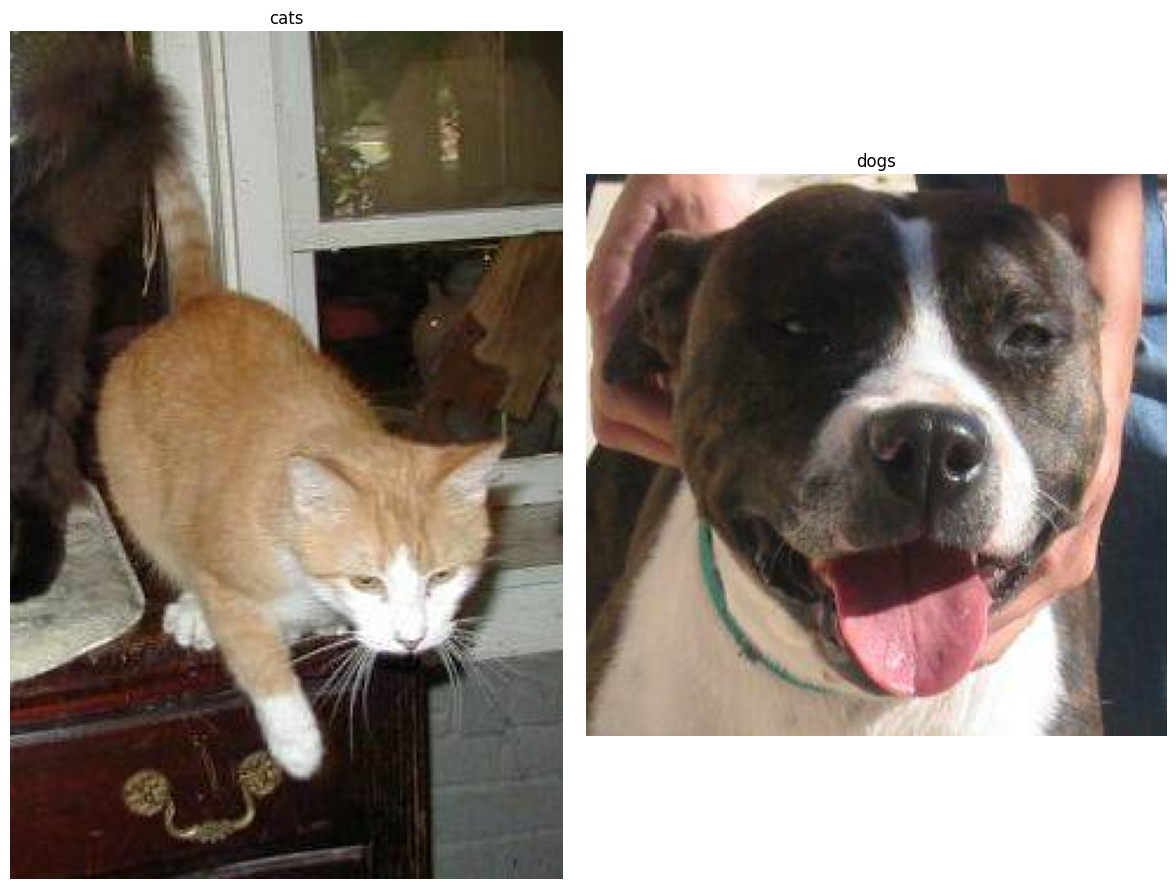

In [38]:
row = 1 
col = 2

plt.figure(figsize=(12, 9))

for i in range(num_classes):
    image = df_singles['Filepath'][i]

    plt.subplot(row, col, i+1)

    plt.imshow(plt.imread(image))

    plt.title(f'{df_singles["Label"][i]}')

    plt.axis('off')

    plt.tight_layout()

plt.show()

# Separação treino e teste

In [49]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.25, stratify=labels, random_state=42)

In [50]:
# Estrutura dos dados está multidimensional: 10000 elementos, 64 linhas, 64 colunas, 3 camadas (RGB)
# É necessário fazer reshape para ter dado unidimensional
print(X_test.shape)
print(X_train.shape)

(5000, 64, 64, 3)
(15000, 64, 64, 3)


# Reshape

In [51]:
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
X_test_flat = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])

In [52]:
X_train_flat.shape

(15000, 12288)

# Label Encoder

Conversão de strings para classes binárias

In [53]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Converte vetor de classes (inteiro) em matriz de classe categórica
y_train_tf = keras.utils.to_categorical(y_train, num_classes)
y_test_tf = keras.utils.to_categorical(y_test, num_classes)

In [54]:
y_test_tf

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)